In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Load the UCI Heart Disease Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
data = pd.read_csv(url, names=column_names, na_values="?")
data = data.dropna()  # Drop rows with missing values
data["target"] = data["target"].apply(lambda x: 1 if x > 0 else 0)  # Binary classification

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
# Split data into features and target
X = data.drop("target", axis=1)
y = data["target"]

In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Function to build the model
from tensorflow.keras.regularizers import l1_l2 # import l1_l2

def build_model(activation="relu", optimizer="adam", l1_reg=0.0, l2_reg=0.0, dropout_rate=0.0):
    model = Sequential()
    # Use l1_l2 to combine L1 and L2 regularization
    model.add(Dense(64, input_dim=X_train.shape[1], activation=activation, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))) 
    model.add(Dropout(dropout_rate))
    for _ in range(4):  # 4 additional hidden layers
        # Use l1_l2 to combine L1 and L2 regularization
        model.add(Dense(64, activation=activation, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))  
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [11]:
# Task 1: Experiment with activation functions
activations = ["relu", "tanh", "sigmoid"]
history_dict = {}
for activation in activations:
    print(f"Training with {activation} activation...")
    model = build_model(activation=activation, optimizer="adam")
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
    history_dict[activation] = history

Training with relu activation...
Training with tanh activation...
Training with sigmoid activation...


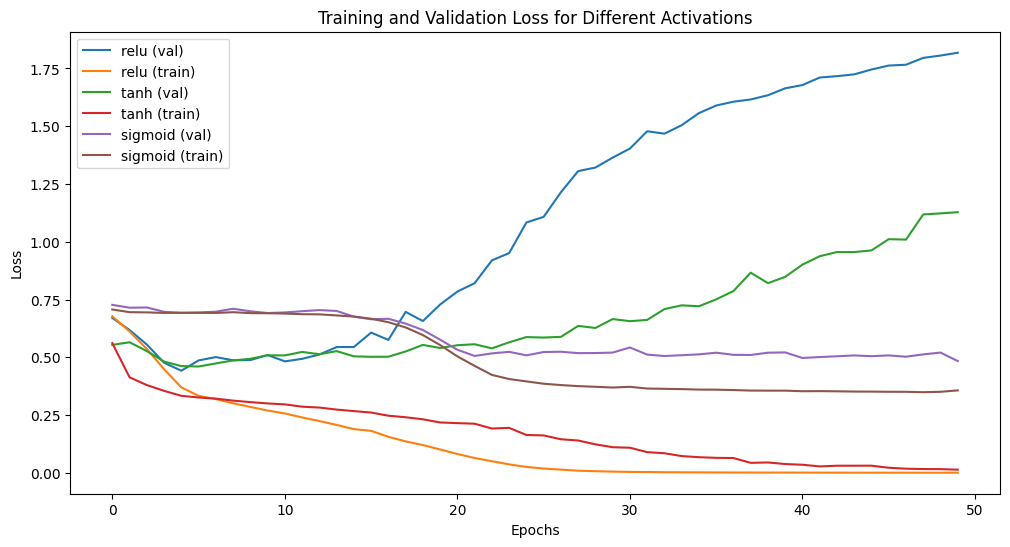

In [12]:
# Plot training and validation loss for each activation
plt.figure(figsize=(12, 6))
for activation in activations:
    plt.plot(history_dict[activation].history["val_loss"], label=f"{activation} (val)")
    plt.plot(history_dict[activation].history["loss"], label=f"{activation} (train)")
plt.title("Training and Validation Loss for Different Activations")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
# Evaluate models with different activations
for activation in activations:
    model = build_model(activation=activation, optimizer="adam")
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\nActivation: {activation}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

2/2 [==============================] - 0s 3ms/step

Activation: relu
Accuracy: 0.8500
Precision: 0.8000
Recall: 0.8333
F1-Score: 0.8163
2/2 [==============================] - 0s 4ms/step

Activation: tanh
Accuracy: 0.8333
Precision: 0.7500
Recall: 0.8750
F1-Score: 0.8077
2/2 [==============================] - 0s 4ms/step

Activation: sigmoid
Accuracy: 0.8667
Precision: 0.8636
Recall: 0.7917
F1-Score: 0.8261


In [14]:
# Task 2: Regularization Techniques
regularization_params = {"l1": [0.001, 0.01, 0.1, 1.0], "l2": [0.001, 0.01, 0.1, 1.0]}
results = []
for reg_type, penalties in regularization_params.items():
    for penalty in penalties:
        print(f"Training with {reg_type} regularization (λ={penalty})...")
        model = build_model(activation="relu", optimizer="adam", l1_reg=penalty if reg_type == "l1" else 0.0, l2_reg=penalty if reg_type == "l2" else 0.0)
        history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        results.append({
            "reg_type": reg_type,
            "penalty": penalty,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred)
        })

Training with l1 regularization (λ=0.001)...
2/2 [==============================] - 0s 4ms/step
Training with l1 regularization (λ=0.01)...
2/2 [==============================] - 0s 3ms/step
Training with l1 regularization (λ=0.1)...
2/2 [==============================] - 0s 3ms/step
Training with l1 regularization (λ=1.0)...
2/2 [==============================] - 0s 2ms/step
Training with l2 regularization (λ=0.001)...
2/2 [==============================] - 0s 2ms/step
Training with l2 regularization (λ=0.01)...
2/2 [==============================] - 0s 2ms/step
Training with l2 regularization (λ=0.1)...
2/2 [==============================] - 0s 3ms/step
Training with l2 regularization (λ=1.0)...
2/2 [==============================] - 0s 3ms/step


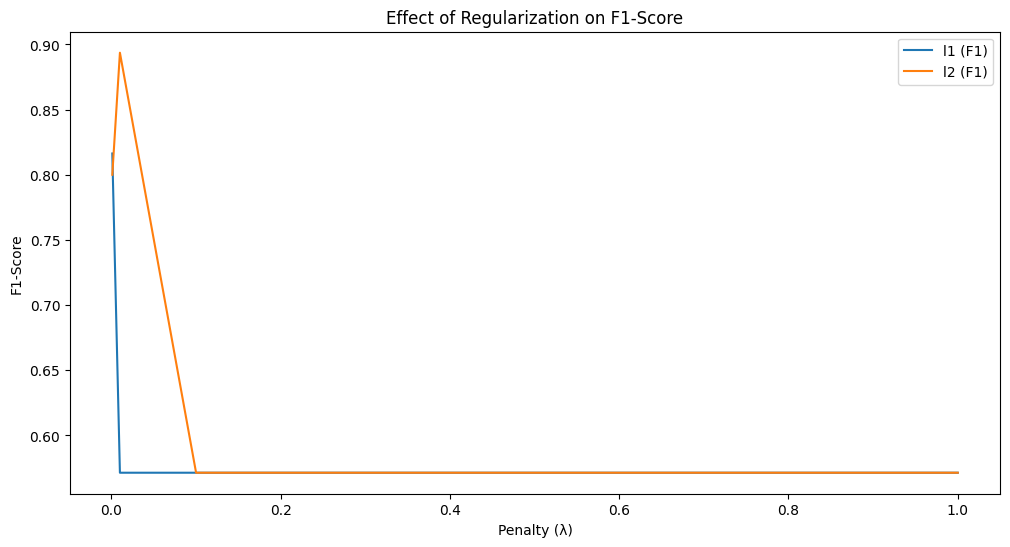

In [15]:
# Plot regularization results
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
for reg_type in ["l1", "l2"]:
    subset = results_df[results_df["reg_type"] == reg_type]
    plt.plot(subset["penalty"], subset["f1_score"], label=f"{reg_type} (F1)")
plt.title("Effect of Regularization on F1-Score")
plt.xlabel("Penalty (λ)")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

In [16]:
# Task 3: Dropout and Hyperparameter Tuning
# Dropout Experiment
dropout_rates = [0.0, 0.2, 0.5, 0.7]
for rate in dropout_rates:
    print(f"Training with dropout rate={rate}...")
    model = build_model(activation="relu", optimizer="adam", dropout_rate=rate)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"Dropout Rate: {rate}, F1-Score: {f1_score(y_test, y_pred):.4f}")

Training with dropout rate=0.0...
2/2 [==============================] - 0s 5ms/step
Dropout Rate: 0.0, F1-Score: 0.8400
Training with dropout rate=0.2...
2/2 [==============================] - 0s 1ms/step
Dropout Rate: 0.2, F1-Score: 0.7826
Training with dropout rate=0.5...
2/2 [==============================] - 0s 2ms/step
Dropout Rate: 0.5, F1-Score: 0.8511
Training with dropout rate=0.7...
2/2 [==============================] - 0s 5ms/step
Dropout Rate: 0.7, F1-Score: 0.0000


In [18]:
!pip install --upgrade scikit-learn scikeras


  Using cached keras-3.8.0-py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 3.8.0 which is incompatible.

[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
!pip install scikit-learn==1.2.2
!pip install scikeras

     ---------------------------------------- 8.3/8.3 MB 212.6 kB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\hp\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~klearn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
pip install --upgrade keras tensorflow


  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl (7.5 kB)
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl (390.2 MB)
  Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\hp\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
pip install --upgrade scikeras


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
pip uninstall keras tensorflow -y

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install tensorflow==2.11 keras==2.11


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.11 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.19.0rc0)
ERROR: No matching distribution found for tensorflow==2.11

[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Hyperparameter Tuning with Grid Search
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(build_fn=build_model, activation="relu", optimizer="adam", verbose=0)
param_grid = {
    "l1_reg": [0.0, 0.001, 0.01],
    "l2_reg": [0.0, 0.001, 0.01],
    "dropout_rate": [0.0, 0.2, 0.5],
    "batch_size": [32, 64],
    "epochs": [50, 100]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1", cv=3)
grid_result = grid.fit(X_train, y_train)

ModuleNotFoundError: No module named 'keras.src'


KeyboardInterrupt

